# Simple Atom Analysis Notebook

#### This notebook is designed to replicate the Mathematica "Single_Atom" Notebook. It's partially a proof of principle that these things can be nicely done in a Jupyter notebook, also to get me familiar with the Python and the Jupyter Notebook, and also to get me more familiar with the analysis

### Initialize Constants

In [1285]:
%matplotlib inline
date = "160519";
fileName = "ProbeBeamHeatingTimeScan";
runNumber = 36;
wellIndicator = 4;
accumulations = 150;
# Zero-indexed!!!
# Horizontal
# atomLocation = [1,wellIndicator-1];
# Vertical
atomLocation = [wellIndicator-1, 1];

picturesPerExperiment = 2;
atomPeakGuess = 400;

In [1286]:
### Uninteresting stuff.
# Data is saved as "data.fits" files
from astropy.io import fits
import numpy
numpy.set_printoptions(threshold=numpy.nan)
import matplotlib.pyplot
import scipy.optimize
import math
import scipy.special
#dataRepositoryPath = "\\\\andor\\share\\Data and documents\\Data repository\\";
todaysDataPath = dataRepositoryPath + date + "\\data_" + str(runNumber) + ".fits";
keyPath = dataRepositoryPath + date + "\\key_" + str(runNumber) + ".txt";
#todaysDataPath = dataRepositoryPath + date + "\\data.fits";
#keyPath = dataRepositoryPath + "Key_file\\key.txt"

### Load Key File

In [1287]:
key = numpy.array([]);
with open(keyPath) as keyFile:
    for line in keyFile:
        key = numpy.append(key, float(line.strip('\n')))

### Load Fits File & Get Dimensions

In [1288]:
# Get the array from the fits file. That's all I care about.
fitsInfo = (fits.open(todaysDataPath, "append"));
fitsInfo.info();
rawData = fitsInfo[0].data;
# the .shape member of an array gives an array of the dimesnions of the array.
numberOfPictures = rawData.shape[0];
numberOfExperiments = int(numberOfPictures / picturesPerExperiment)
horizontalImageDimension = rawData.shape[1];
verticalImageDimension = rawData.shape[2];

Filename: \\andor\share\Data and documents\Data repository\160519\data_35.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (3, 9, 300)   int32   


### Initial Data Analysis

In [1289]:
peakData = [];
backgroundData = [];
firstExperimentData = [];
for imageInc in range(0, numberOfPictures - 1):
    averageBackground = 1/4*(rawData[imageInc][0][0] + rawData[imageInc][horizontalImageDimension-1][verticalImageDimension-1] 
                             + rawData[imageInc][0][verticalImageDimension-1] + rawData[imageInc][horizontalImageDimension-1][0])
    peakData = numpy.append(peakData, rawData[imageInc][atomLocation[0]][atomLocation[1]] - averageBackground);
    backgroundData = numpy.append(backgroundData, averageBackground);
    if imageInc % 2 == 0:
        firstExperimentData = numpy.append(firstExperimentData, rawData[imageInc][atomLocation[0]][atomLocation[1]]
                                           - averageBackground);


### Histogram

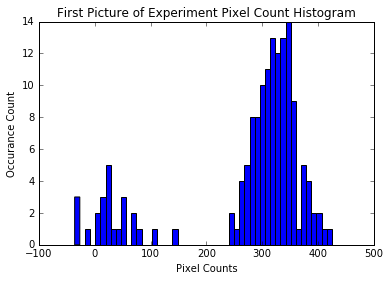

In [1290]:
matplotlib.pyplot.hist(firstExperimentData, 50);
matplotlib.pyplot.title("First Picture of Experiment Pixel Count Histogram");
matplotlib.pyplot.ylabel("Occurance Count");
matplotlib.pyplot.xlabel("Pixel Counts");

### Calculate Atom Threshold

-36.0
Threshold Found: 160.798325902
Threshold Fidelity: 99.9872063073%
Loading Efficiency: 84.0%


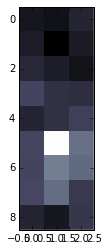

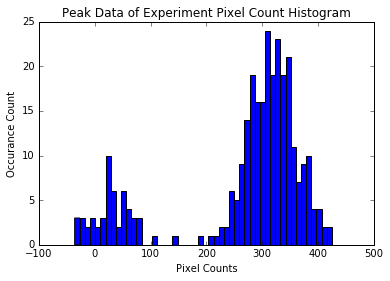

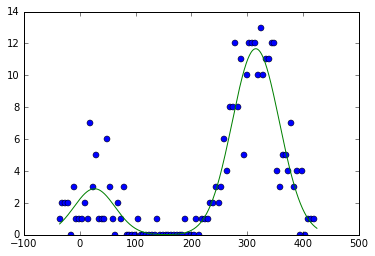

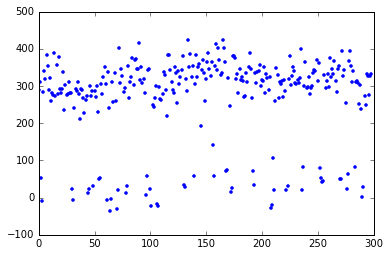

In [1291]:
#define the fitting function
def doubleGaussian(data, A1, x1, sig1, A2, x2, sig2):
    return (A1 * numpy.exp(-((data-x1)/(numpy.sqrt(2)*sig1))**2)) + A2*numpy.exp(-((data-x2)/(numpy.sqrt(2)*sig2))**2)
# calculate the bin width... (unused?)
binWidth = 5;
binBorderLocation = min(peakData);
print(binBorderLocation);
binsBorders = numpy.array([]);
# get bin borders
while binBorderLocation < max(peakData):
    binsBorders = numpy.append(binsBorders, binBorderLocation);
    binBorderLocation = binBorderLocation + binWidth;
#binsBorders = numpy.linspace(min(peakData),max(peakData),50);
# trash gets set but is unused.
binnedData, trash = numpy.histogram(peakData, binsBorders);
binCenters = binsBorders[0:binsBorders.size-1];

# get centered data points
# for binInc in range(0, binsBorders.size - 1):
#     binCenters = numpy.append(binCenters, (binsBorders[binInc] + binsBorders[binInc + 1])/2);
# fit the histogram
#                   A1     x1  s1  a2   x2            s2
guess = numpy.array([100, 0, 30, 200, atomPeakGuess, 10]);

fitVals, trash = scipy.optimize.curve_fit(doubleGaussian, binCenters, binnedData, guess);
# make an image
matplotlib.pyplot.figure(0);
matplotlib.pyplot.imshow(rawData[100], interpolation='none', cmap = matplotlib.cm.get_cmap("bone"));
# make a histogram
matplotlib.pyplot.figure(1);
matplotlib.pyplot.hist(peakData, 50);
matplotlib.pyplot.title("Peak Data of Experiment Pixel Count Histogram");
matplotlib.pyplot.ylabel("Occurance Count");
matplotlib.pyplot.xlabel("Pixel Counts");
# plot the fit on top of the histogram
matplotlib.pyplot.figure(2);
matplotlib.pyplot.plot(binCenters, binnedData, "o");
fineXData = numpy.linspace(min(peakData),max(peakData),500);
matplotlib.pyplot.plot(fineXData, doubleGaussian(fineXData,*fitVals))
matplotlib.pyplot.figure(3);
matplotlib.pyplot.plot(peakData, ".");

TCalc = (fitVals[4] - fitVals[1])/(numpy.abs(fitVals[5]) + numpy.abs(fitVals[2]));
threshold = fitVals[1] + TCalc * fitVals[2];
thresholdFidelity = 1/2 * (1 + scipy.special.erf(TCalc/numpy.sqrt(2)))
print("Threshold Found: " + str(threshold))
print("Threshold Fidelity: " + str(thresholdFidelity * 100) + "%")

atomCount = 0;
for experimentInc in range(0, firstExperimentData.size):
    if firstExperimentData[experimentInc] > threshold:
        atomCount += 1;
print("Loading Efficiency: " + str(atomCount / firstExperimentData.size * 100) + "%")

### Coalate Data

In [1292]:
numberTransfered = 0;
transferedArray = numpy.array([]);
transferedArray.astype(int);
# this doesn't take into account loss!
for experimentInc in range(0, numberOfExperiments - 1):
    if peakData[2 * experimentInc] > threshold and peakData[2 * experimentInc + 1] >= threshold:
        numberTransfered = numberTransfered + 1;
        #true
        transferedArray = numpy.append(transferedArray, 1);
    elif peakData[2 * experimentInc] > threshold and peakData[2 * experimentInc + 1] < threshold:
        transferedArray = numpy.append(transferedArray, 0);
    else:
        #false
        transferedArray = numpy.append(transferedArray, -1);
fractionTransfered = numberTransfered / numberOfExperiments;

In [1293]:
# Get Data in final form for exporting
averageFractionTransfered = numpy.array([]);
captureProbabilities = numpy.array([]);
standardDeviation = numpy.array([]);
ctsList =numpy.array([]);
lctsList = numpy.array([]);
stdevC = numpy.array([]);
for variationInc in range(0, int(transferedArray.size / (accumulations - 1)) ):
    cts = numpy.array([]);
    for accumulationInc in range(0, accumulations - 1):
        if transferedArray[variationInc * accumulations + accumulationInc] != -1:
            cts = numpy.append(cts, transferedArray[variationInc * accumulations + accumulationInc]);
    if cts.size == 0:
        #print(cts.size)
        standardDeviation = numpy.append(standardDeviation, 0);
        captureProbabilities = numpy.append(captureProbabilities, 0);
        averageFractionTransfered = numpy.append(averageFractionTransfered, 0);
        ctsList = numpy.append(ctsList, 0);
        lctsList = numpy.append(lctsList, 0);
        stdevC = numpy.append(stdevC, 0);
    else:
        #print(cts.size)
        standardDeviation = numpy.append(standardDeviation, numpy.std(cts)/numpy.sqrt(cts.size));
        captureProbabilities = numpy.append(captureProbabilities, cts.size / accumulations);
        averageFractionTransfered = numpy.append(averageFractionTransfered, numpy.average(cts));
        ctsList = numpy.append(ctsList, numpy.average(cts.size));
        lctsList = numpy.append(lctsList, numpy.sqrt(cts.size));
        stdevC = numpy.append(stdevC, numpy.std(cts));
dataSpectra = numpy.column_stack((numpy.array(key), averageFractionTransfered))
survivalData = numpy.column_stack((dataSpectra, standardDeviation));
fullCaptureProbabilitiyData = numpy.column_stack((numpy.array(key), captureProbabilities));
collatedData = [accumulations, peakData, key, survivalData, captureProbabilities, rawData, fullCaptureProbabilitiyData];

### Initial Plots

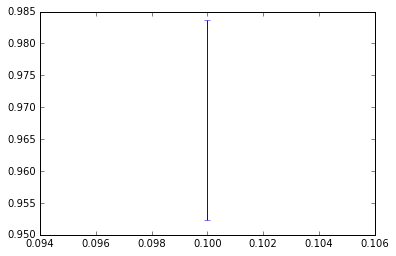

In [1294]:
matplotlib.pylab.errorbar(numpy.array(key), averageFractionTransfered, 
                          yerr=standardDeviation, linestyle = "none");

In [1295]:
averageFractionTransfered

array([ 0.968])

### Export Data And Close

In [1296]:
fitsInfo.close()
#collatedData = [accumulations, peakData, key, survivalData, captureProbabilities, rawData, captureProbabilities];
outputName = dataRepositoryPath + date + "\\" + fileName + "_run" + str(runNumber) + "_well" + str(wellIndicator)+ ".tsv";
print(outputName)
with open(outputName, "w") as record_file:
    # accumulations is special since it's an integer.
    record_file.write(str(collatedData[0]) + "\n");
    ### Version for mathematica compatibility
    # Peak Data
    for peakInc in range(0, peakData.size):
        record_file.write(str(peakData[peakInc]) + "\t");
    record_file.write("\n");
    # key
    for keyInc in range(0, key.size-1):
        record_file.write(str(key[keyInc]) + "\t");
    record_file.write(str(key[key.size-1]));
    record_file.write("\n");
    # survival data
    survivalDimensions = survivalData.shape;
    for survivalPointsInc in range(0, survivalDimensions[0]-1):
        record_file.write(str("{{"));
        record_file.write(str(survivalData[survivalPointsInc][0]) + ", ");
        record_file.write(str(survivalData[survivalPointsInc][1]) + "}, ");
        record_file.write("ErrorBar[" + str(survivalData[survivalPointsInc][2]) + "]");
        record_file.write(str("}\t"));
    record_file.write(str("{{"));
    record_file.write(str(survivalData[survivalDimensions[0]-1][0]) + ", ");
    record_file.write(str(survivalData[survivalDimensions[0]-1][1]) + "}, ");
    record_file.write("ErrorBar[" + str(survivalData[survivalDimensions[0]-1][2]) + "]");
    record_file.write(str("}"));
    record_file.write("\n")
        # capture probabilities data
    for captureInc in range(0, captureProbabilities.size):
        record_file.write(str(captureProbabilities[captureInc]) + " ");
    record_file.write("\n");
    # raw data
    rawDataDimensions = rawData.shape;
    for pictureInc in range(0, rawDataDimensions[0]):
        record_file.write("{");
        for rowInc in range(0, rawDataDimensions[1]):
            record_file.write("{");
            for columnInc in range(0, rawDataDimensions[2]):
                record_file.write(str(rawData[pictureInc][rowInc][columnInc]) + " ")
            record_file.write("} ")
        record_file.write("}");
    record_file.write("\n");
    # full Capture Probabilitiy Data (capture probabilities with x values?)
    fullCaptureDataDimensions = fullCaptureProbabilitiyData.shape;
    for variationInc in range(0, fullCaptureDataDimensions[0]):
        record_file.write("{" + str(fullCaptureProbabilitiyData[variationInc][0]) + ", "
                          + str(fullCaptureProbabilitiyData[variationInc][1]) + "} ");
    
    # sensible version
    # for dataInc in range(1,len(collatedData)):
        
        #record_file.write(str(collatedData[dataInc][0:len(collatedData[dataInc])]) + "\n");
        

\\andor\share\Data and documents\Data repository\160519\ProbeBeamHeating1Point_run35_well4.tsv
